# Customer Support

Here, we show an example of building a customer support chatbot.

This customer support chatbot interacts with SQL database to answer questions.
We will use a mock SQL database to get started: the [Chinook](https://www.sqlitetutorial.net/sqlite-sample-database/) database.
This database is about sales from a music store: what songs and albums exists, customer orders, things like that.

This chatbot has two different states: 
1. Music: the user can inquire about different songs and albums present in the store
2. Account: the user can ask questions about their account

Under the hood, this is handled by two separate agents. 
Each has a specific prompt and tools related to their objective. 
There is also a generic agent who is responsible for routing between these two agents as needed.

In [1]:
#%pip install -U langgraph langchain-openai langchain-community scikit-learn langgraph-checkpoint-sqlite python-dotenv --quiet

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

## Load the data

In [3]:
from langchain_community.utilities.sql_database import SQLDatabase

# Correct the path to point to the database
db = SQLDatabase.from_uri("sqlite:///../data/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


## Load an LLM

We will load a language model to use.
For this demo we will use OpenAI.

In [4]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo-preview")

## Load Other Modules

Load other modules we will use.

All of the tools our agents will use will be custom tools. As such, we will use the `@tool` decorator to create custom tools.

We will pass in messages to the agent, so we load `HumanMessage` and `SystemMessage`

In [5]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

## Define the Customer Agent

This agent is responsible for looking up customer information.
It will have a specific prompt as well a specific tool to look up information about that customer (after asking for their user id).

In [6]:
# Define the tool for looking up customer information
@tool
def get_customer_info(customer_id: int):
    """
    Retrieve customer information from the database using their unique customer ID.

    This tool queries the 'customers' table in the Chinook database to fetch information 
    about a specific customer. It is essential to ensure that the customer ID is provided 
    and is valid before invoking this function.

    Parameters:
    ----------
    customer_id : int
        The unique identifier for the customer in the database.

    Returns:
    -------
    dict
        A dictionary containing the customer's information if the ID is valid and exists 
        in the database.
    
    Notes:
    ------
    - ALWAYS confirm that the customer ID is available and valid before calling this function.
    - If the customer ID is invalid or does not exist, the function will return an appropriate 
      error message.
    - Example usage:
        `get_customer_info(1)` will fetch information for the customer with ID 1.
    """
    # Validate that a customer ID is provided
    if not isinstance(customer_id, int) or customer_id <= 0:
        return {"error": "Invalid customer ID. Please provide a valid positive integer."}
    
    # Query the database for customer information
    try:
        result = db.run(f"SELECT * FROM customers WHERE CustomerID = {customer_id};")
        if result:
            return result
        else:
            return {"error": f"No customer found with ID {customer_id}."}
    except Exception as e:
        return {"error": f"An error occurred while fetching customer info: {str(e)}"}


In [7]:
import sqlite3

@tool
def update_customer_profile(customer_id: int, field: str, new_value: str):
    """
    Update a specific field in a customer's profile.

    Parameters:
    ----------
    customer_id : int
        The unique identifier for the customer in the database.
    field : str
        The name of the field to update (e.g., 'FirstName', 'LastName', 'Email').
    new_value : str
        The new value to update in the specified field.

    Returns:
    -------
    dict
        A dictionary containing a success message or an error message.
    """
    print(f"Received inputs - Customer ID: {customer_id}, Field: {field}, New Value: {new_value}")

    # Validate inputs
    if not isinstance(customer_id, int) or customer_id <= 0:
        return {"error": "Invalid customer ID. Please provide a valid positive integer."}

    valid_fields = [
        "FirstName", "LastName", "Company", "Address", "City", "State",
        "Country", "PostalCode", "Phone", "Fax", "Email", "SupportRepId"
    ]
    if field not in valid_fields:
        return {"error": f"Invalid field '{field}'. Allowed fields are: {', '.join(valid_fields)}"}
    
    if not isinstance(new_value, str) or len(new_value.strip()) == 0:
        return {"error": "Invalid value. Please provide a valid new value."}

    try:
        # Connect to the database directly
        conn = sqlite3.connect("../data/chinook.db")  
        cursor = conn.cursor()

        # Parameterized query
        query = f"UPDATE customers SET {field} = ? WHERE CustomerID = ?;"
        print(f"Executing query: {query} with params: ({new_value}, {customer_id})")

        # Execute query
        cursor.execute(query, (new_value, customer_id))
        conn.commit()  # Commit the changes
        rows_affected = cursor.rowcount

        cursor.close()
        conn.close()

        # Check if the update was successful
        if rows_affected == 0:
            return {"error": f"No rows updated. Ensure Customer ID {customer_id} exists in the database."}
        
        return {"success": f"{field} for customer ID {customer_id} updated to '{new_value}'."}

    except sqlite3.Error as e:
        error_message = f"An error occurred while updating the field '{field}': {str(e)}"
        print(f"Error details: {error_message}")
        return {"error": error_message}

    except Exception as e:
        print(f"Unhandled exception: {str(e)}")
        return {"error": "An unexpected error occurred."}




In [8]:
# update_customer_profile(1, "Email", "newemail@example.com")


In [9]:
# Define the customer prompt
customer_prompt = """
Your role is to assist a user in viewing or updating their profile information.

You have access to the following tools to perform these tasks:
1. `get_customer_info`: Retrieve information about a specific customer using their unique customer ID.
   - Required input: `customer_id`
   - Example: "What is your customer ID so I can retrieve your profile?"

2. `update_customer_profile`: Update a specific field in the customer's profile.
   - Required inputs:
     - `customer_id`: The unique ID of the customer.
     - `field`: The name of the profile field to update (e.g., "FirstName", "Email", "Phone").
     - `new_value`: The new value to assign to the specified field.
   - Example: "Could you confirm your customer ID and provide the new email address you'd like to update?"

Steps to assist the user:
- Always verify you have all the required inputs before using a tool.
- If a user wants to update a field (e.g., their email or phone number), ask for the relevant inputs:
  - For first name updates: Ask for the new first name.
  - For email updates: Ask for the new email address.
  - For phone updates: Ask for the new phone number.
  - For other fields: Clarify the field name and the new value.

Example interactions:
1. To retrieve profile information:
   - "What is your customer ID so I can look up your profile?"
2. To update the profile:
   - "What is your customer ID, and which field would you like to update? Please provide the new value for that field."

Important Notes:
- If the user requests to update a field that is invalid or unavailable, inform them politely of the valid fields:
  - Allowed fields: `FirstName`, `LastName`, `Company`, `Address`, `City`, `State`, `Country`, `PostalCode`, `Phone`, `Fax`, `Email`, and `SupportRepId`.
- If you are unable to assist with the user's request, politely suggest they contact customer support.

If the user provides all necessary inputs, proceed to execute the appropriate tool and confirm the changes.
"""


def get_customer_messages(messages):
    """
    Generate the message sequence for a customer support agent to assist users with profile updates.

    This function combines a predefined system prompt with the user-provided messages 
    to create the complete input sequence for the agent. The prompt ensures the agent 
    follows a specific protocol when interacting with the user.

    Parameters:
    ----------
    messages : list
        A list of user-provided messages (usually instances of `UserMessage`) 
        that the agent needs to process.

    Returns:
    -------
    list
        A list of `SystemMessage` and user messages to initialize the customer support chain. 
        The first message is the system prompt, followed by the user-provided messages.

    Notes:
    ------
    - The system prompt ensures the agent:
      - Focuses on helping users update their profile.
      - Requests necessary inputs if they are missing.
      - Politely informs users if assistance cannot be provided, suggesting alternative help.
    - Example usage:
        ```
        user_messages = [UserMessage(content="I need to change my email address.")]
        conversation = get_customer_messages(user_messages)
        ```
    """
    # Combine the system message with user-provided messages
    return [SystemMessage(content=customer_prompt)] + messages

In [10]:
# Define the customer chain, binding tools for profile updates
customer_chain = get_customer_messages | model.bind_tools([
    get_customer_info,
    update_customer_profile
])

In [11]:
update_customer_profile

StructuredTool(name='update_customer_profile', description="Update a specific field in a customer's profile.\n\nParameters:\n----------\ncustomer_id : int\n    The unique identifier for the customer in the database.\nfield : str\n    The name of the field to update (e.g., 'FirstName', 'LastName', 'Email').\nnew_value : str\n    The new value to update in the specified field.\n\nReturns:\n-------\ndict\n    A dictionary containing a success message or an error message.", args_schema=<class 'langchain_core.utils.pydantic.update_customer_profile'>, func=<function update_customer_profile at 0x122cd6de0>)

## Define the Music Agent

This agent is responsible for figuring out information about music. To do that, we will create a prompt and various tools for looking up information about music

First, we will create indexes for looking up artists and track names.
This will allow us to look up artists and tracks without having to spell their names exactly right.

In [12]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain.embeddings.openai import OpenAIEmbeddings

def create_music_retrievers(database):
    """
    Create retrievers for looking up artists and tracks using approximate matching.

    This function uses a vector-based search mechanism to create retrievers for artists and 
    track names from the Chinook database. It enables efficient and error-tolerant lookups 
    of artist and track names without requiring exact spelling.

    Parameters:
    ----------
    database : SQLDatabase
        An instance of the SQLDatabase connected to the Chinook database.

    Returns:
    -------
    tuple
        A tuple containing:
        - artist_retriever: A retriever for searching artist names.
        - song_retriever: A retriever for searching track names.

    Notes:
    ------
    - The function queries the database for artists and tracks, retrieves their names, 
      and indexes them into separate retrievers.
    - OpenAI embeddings are used for generating vector representations of the names.
    - The retrievers allow for approximate matching, making it user-friendly for misspelled 
      or partially remembered artist/track names.

    Example Usage:
    --------------
        db = SQLDatabase.from_uri("sqlite:///../data/chinook.db")
        artist_retriever, song_retriever = create_music_retrievers(db)
    """
    try:
        # Query the database for artists and tracks
        artists = database._execute("SELECT * FROM artists")
        songs = database._execute("SELECT * FROM tracks")

        # Validate query results
        if not artists:
            raise ValueError("No artists found in the database.")
        if not songs:
            raise ValueError("No tracks found in the database.")

        # Extract artist and track names for embedding
        artist_names = [artist['Name'] for artist in artists]
        track_names = [track['Name'] for track in songs]

        # Create retrievers for artists and songs
        artist_retriever = SKLearnVectorStore.from_texts(
            texts=artist_names,
            embedding=OpenAIEmbeddings(),
            metadatas=artists
        ).as_retriever()

        song_retriever = SKLearnVectorStore.from_texts(
            texts=track_names,
            embedding=OpenAIEmbeddings(),
            metadatas=songs
        ).as_retriever()

        return artist_retriever, song_retriever

    except Exception as e:
        raise RuntimeError(f"Error creating music retrievers: {str(e)}")


In [13]:
# Define global variables
artist_retriever = None
song_retriever = None

def initialize_retrievers(database):
    global artist_retriever, song_retriever
    artist_retriever, song_retriever = create_music_retrievers(database)

# Call this once during setup
initialize_retrievers(db)

/var/folders/1q/tw0_228j0md30_b1bkb34hfr0000gn/T/ipykernel_60786/162408081.py:55: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding=OpenAIEmbeddings(),


In [14]:
# Test the retrievers
try:
    print(artist_retriever.get_relevant_documents("The Beatles"))
    print(song_retriever.get_relevant_documents("Hello"))
except Exception as e:
    print(f"Test failed: {e}")


/var/folders/1q/tw0_228j0md30_b1bkb34hfr0000gn/T/ipykernel_60786/1346224990.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(artist_retriever.get_relevant_documents("The Beatles"))


[Document(metadata={'id': '517e4521-692e-4de8-91fa-eca7d10f0db0', 'ArtistId': 142, 'Name': 'The Rolling Stones'}, page_content='The Rolling Stones'), Document(metadata={'id': 'df430791-5edb-4989-8f72-c7353ebcf64f', 'ArtistId': 120, 'Name': 'Pink Floyd'}, page_content='Pink Floyd'), Document(metadata={'id': 'f9666177-0e79-4750-9387-f53ded27a6fb', 'ArtistId': 84, 'Name': 'Foo Fighters'}, page_content='Foo Fighters'), Document(metadata={'id': '11a6312c-6871-4c90-8172-4efb05e679d0', 'ArtistId': 247, 'Name': "The King's Singers"}, page_content="The King's Singers")]
[Document(metadata={'id': 'bf7f8a5d-5a2f-4983-85f0-acbb24c47be8', 'TrackId': 911, 'Name': 'Hey Hey', 'AlbumId': 73, 'MediaTypeId': 1, 'GenreId': 6, 'Composer': 'Big Bill Broonzy', 'Milliseconds': 196466, 'Bytes': 6543487, 'UnitPrice': 0.99}, page_content='Hey Hey'), Document(metadata={'id': '4acd0b66-4cda-4323-8c94-037b41c26273', 'TrackId': 3301, 'Name': 'Salutations', 'AlbumId': 258, 'MediaTypeId': 1, 'GenreId': 17, 'Composer':

First, let's create a tool for getting albums by artist.

In [15]:
@tool
def get_albums_by_artist(artist_name: str):
    """
    Retrieve a list of albums by a given artist or similar artists using approximate matching.

    This tool leverages the `artist_retriever` to find artists whose names closely match 
    the provided input and then queries the database to get the albums associated with 
    those artists.

    Parameters:
    ----------
    artist_name : str
        The name of the artist to search for.

    Returns:
    -------
    list
        A list of dictionaries, where each dictionary contains:
        - Title: The album title.
        - Name: The artist's name.

    Notes:
    ------
    - If no matching artists are found, an appropriate message will be returned.
    - Uses approximate matching via the `artist_retriever` to handle typos and partial matches.
    - Example usage:
        `get_albums_by_artist("The Beatles")` retrieves albums for "The Beatles" or similar artists.

    Example Response:
    -----------------
        [
            {"Title": "Revolver", "Name": "The Beatles"},
            {"Title": "Abbey Road", "Name": "The Beatles"}
        ]
    """
    try:
        # Find relevant artists using the retriever
        docs = artist_retriever.get_relevant_documents(artist_name)
        
        # Check if any artists were found
        if not docs:
            return {"error": f"No artists found matching '{artist_name}'. Please try another name."}
        
        # Extract artist IDs from the retrieved documents
        artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
        
        # Query the database for albums by the retrieved artists
        query = f"""
        SELECT 
            albums.Title AS Title, 
            artists.Name AS Name 
        FROM 
            albums 
        LEFT JOIN 
            artists 
        ON 
            albums.ArtistId = artists.ArtistId 
        WHERE 
            albums.ArtistId IN ({artist_ids});
        """
        result = db.run(query, include_columns=True)
        
        # Check if any albums were found
        if not result:
            return {"message": f"No albums found for artists similar to '{artist_name}'."}
        
        return result

    except Exception as e:
        return {"error": f"An error occurred while fetching albums: {str(e)}"}


Next, lets create a tool for getting tracks by an artist

In [16]:
@tool
def get_tracks_by_artist(artist_name: str):
    """
    Retrieve a list of tracks by a given artist or similar artists using approximate matching.
    """
    # Validate retriever initialization
    if artist_retriever is None:
        return {"error": "Artist retriever is not initialized. Please ensure the retrievers are set up."}

    try:
        # Retrieve relevant artists using the retriever
        docs = artist_retriever.get_relevant_documents(artist_name)
    
        artist_ids = ", ".join([str(doc.metadata["ArtistId"]) for doc in docs])
        
        # Query the database for tracks by the retrieved artists (case-insensitive)
        query = f"""
        SELECT 
            tracks.Name AS SongName, 
            artists.Name AS ArtistName 
        FROM 
            albums 
        LEFT JOIN 
            artists 
        ON 
            albums.ArtistId = artists.ArtistId 
        LEFT JOIN 
            tracks 
        ON 
            tracks.AlbumId = albums.AlbumId 
        WHERE 
            LOWER(artists.Name) = LOWER('{artist_name}')
            OR albums.ArtistId IN ({artist_ids});
        """
        result = db.run(query, include_columns=True)
        
        if not result:
            return {"message": f"No tracks found for artists similar to '{artist_name}'."}
        
        return result

    except Exception as e:
        return {"error": f"An error occurred while fetching tracks: {str(e)}"}


# @tool
# def get_tracks_by_artist(artist):
#     """Get songs by an artist (or similar artists)."""
#     docs = artist_retriever.get_relevant_documents(artist)
#     artist_ids = ", ".join([str(d.metadata['ArtistId']) for d in docs])
#     return db.run(f"SELECT tracks.Name as SongName, artists.Name as ArtistName FROM albums LEFT JOIN artists ON albums.ArtistId = artists.ArtistId LEFT JOIN tracks ON tracks.AlbumId = albums.AlbumId WHERE albums.ArtistId in ({artist_ids});", include_columns=True)


In [17]:
get_albums_by_artist('Amy Winehouse')

/var/folders/1q/tw0_228j0md30_b1bkb34hfr0000gn/T/ipykernel_60786/1255475146.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_albums_by_artist('Amy Winehouse')


"[{'Title': 'Jagged Little Pill', 'Name': 'Alanis Morissette'}, {'Title': 'Audioslave', 'Name': 'Audioslave'}, {'Title': 'Out Of Exile', 'Name': 'Audioslave'}, {'Title': 'Revelations', 'Name': 'Audioslave'}, {'Title': 'Bark at the Moon (Remastered)', 'Name': 'Ozzy Osbourne'}, {'Title': 'Blizzard of Ozz', 'Name': 'Ozzy Osbourne'}, {'Title': 'Diary of a Madman (Remastered)', 'Name': 'Ozzy Osbourne'}, {'Title': 'No More Tears (Remastered)', 'Name': 'Ozzy Osbourne'}, {'Title': 'Tribute', 'Name': 'Ozzy Osbourne'}, {'Title': 'Speak of the Devil', 'Name': 'Ozzy Osbourne'}, {'Title': 'Back to Black', 'Name': 'Amy Winehouse'}, {'Title': 'Frank', 'Name': 'Amy Winehouse'}]"

Finally, let's create a tool for looking up songs by their name.

In [18]:
@tool
def check_for_songs(song_title: str):
    """
    Search for songs by title using approximate matching.

    This tool uses the `song_retriever` to find songs whose titles closely match 
    the provided input. It returns relevant information about the songs.

    Parameters:
    ----------
    song_title : str
        The title of the song to search for.

    Returns:
    -------
    list
        A list of dictionaries with song details or a message if no matches are found.

    Notes:
    ------
    If no exact match is found, it returns similar titles.
    """
    try:
        # Retrieve relevant songs using the retriever
        docs = song_retriever.get_relevant_documents(song_title)
        
        # Check if any songs were found
        if not docs:
            return {"message": f"No songs found matching '{song_title}'. Please try another title."}
        
        # Extract relevant details from the retrieved documents
        songs = [
            {
                "Name": doc.metadata.get("Name", "Unknown"),
                "AlbumId": doc.metadata.get("AlbumId"),
                "TrackId": doc.metadata.get("TrackId"),
                "Metadata": doc.metadata,  # Include all metadata if needed
            }
            for doc in docs
        ]
        
        return songs

    except Exception as e:
        return {"error": f"An error occurred while searching for songs: {str(e)}"}


Create the chain to call the relevant tools

In [19]:
# Define the system message for the song recommendation agent
song_system_message = """
Your job is to assist a customer in finding any songs they are looking for.

You have access to specific tools to look up songs, albums, or artists. If a customer asks for something you cannot assist with, 
politely inform them of the limitations and let them know what you can help with.


When looking up artists and songs, sometimes the exact match may not be found. In such cases, the tools are designed to return 
information about similar songs or artists. This is intentional and helps provide relevant recommendations.
"""


def get_song_messages(messages):
    """
    Prepares the conversation input for the song recommendation agent.

    This function combines a predefined system message with user-provided messages 
    to create the input sequence for the chain. The system message ensures the agent 
    follows specific guidelines for assisting customers.

    Parameters:
    ----------
    messages : list
        A list of user-provided messages (usually instances of `UserMessage`) 
        that the agent needs to process.

    Returns:
    -------
    list
        A list of `SystemMessage` followed by user messages to initialize the chain.

    Example Usage:
    --------------
        user_messages = [UserMessage(content="Find songs by The Beatles.")]
        conversation = get_song_messages(user_messages)
    """
    return [SystemMessage(content=song_system_message)] + messages

# Define the chain for song recommendations
song_recc_chain = get_song_messages | model.bind_tools(
    [
        get_albums_by_artist,  # Tool to retrieve albums by an artist
        get_tracks_by_artist,  # Tool to retrieve tracks by an artist
        check_for_songs        # Tool to check for songs by name
    ]
)


In [20]:
msgs = [HumanMessage(content="hi! can you help me find songs by amy whinehouse?")]
song_recc_chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_KklZxwzUg0Byg4mNvE0xLtXY', 'function': {'arguments': '{"artist_name":"amy whinehouse"}', 'name': 'get_tracks_by_artist'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-0125-preview'}, id='run-2e6cdef3-ef07-480e-b85e-50cf8bae8290-0', tool_calls=[{'name': 'get_tracks_by_artist', 'args': {'artist_name': 'amy whinehouse'}, 'id': 'call_KklZxwzUg0Byg4mNvE0xLtXY', 'type': 'tool_call'}])

## Define the Generic Agent

We now define a generic agent that is responsible for handling initial inquiries and routing to the right sub agent.

In [21]:
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

# Define the Router model
class Router(BaseModel):
    """
    A routing model responsible for determining the appropriate agent
    to handle user inquiries based on the context of their message.

    Attributes:
    ----------
    choice : str
        Specifies the agent to route to. Should be one of:
        - 'music' for inquiries related to music recommendations or music information.
        - 'customer' for inquiries related to updating or accessing user information.
    """
    choice: str = Field(description="Should be one of: 'music', 'customer'.")




# Define the system message for the generic agent
system_message = """
Your job is to serve as a polite and helpful customer service representative for a music store.

You can assist customers in the following ways:
1. **Updating user information**:
    - If the customer wants to update or access their information in the user database, route them to `customer`.
2. **Recommending music**:
    - If the customer wants to find music or learn about music, route them to `music`.

Routing Instructions:
- If the user mentions updating or accessing their personal information, call the router with 'customer'.
- If the user mentions music recommendations or any music-related inquiry, call the router with 'music'.
- For any other inquiries, respond politely and explain what you can assist with.

Always aim to be polite and clear in your interactions.
"""

# Define a function to prepare messages
def get_messages(messages):
    """
    Prepares a conversation by combining a predefined system message 
    with user-provided messages to form the input sequence.

    Parameters:
    ----------
    messages : list
        A list of user-provided messages (usually instances of `HumanMessage`) 
        that the agent needs to process.

    Returns:
    -------
    list
        A list of `SystemMessage` followed by user messages to initialize the conversation.

    Example Usage:
    --------------
        user_messages = [HumanMessage(content="Can I update my address?")]
        conversation = get_messages(user_messages)
    """
    return [SystemMessage(content=system_message)] + messages


In [22]:
chain = get_messages | model.bind_tools([Router])

In [23]:
msgs = [HumanMessage(content="hi! can you help me find a good song?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_JMKCNPMlLnCqFuFRufx3jgcr', 'function': {'arguments': '{"choice":"music"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-0125-preview'}, id='run-faa08094-a4ff-4a1c-88e2-adb26bb83d5a-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'music'}, 'id': 'call_JMKCNPMlLnCqFuFRufx3jgcr', 'type': 'tool_call'}])

In [24]:
msgs = [HumanMessage(content="hi! whats the email you have for me?")]
chain.invoke(msgs)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_rhC1IUuFP6MlXORRl9dFHzUu', 'function': {'arguments': '{"choice":"customer"}', 'name': 'Router'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-0125-preview'}, id='run-9b35578a-8f6e-4868-bd78-30300a6fbd9d-0', tool_calls=[{'name': 'Router', 'args': {'choice': 'customer'}, 'id': 'call_rhC1IUuFP6MlXORRl9dFHzUu', 'type': 'tool_call'}])

In [25]:
from langchain_core.messages import AIMessage

def add_name(message: AIMessage, name: str) -> AIMessage:
    """
    Add or update the 'name' attribute in an AIMessage instance.

    This function takes an AIMessage object, adds or updates its 'name' attribute, 
    and returns a new AIMessage instance with the modified attribute.

    Parameters:
    ----------
    message : AIMessage
        The original AIMessage object to be modified.
    name : str
        The name to be added or updated in the AIMessage.

    Returns:
    -------
    AIMessage
        A new AIMessage instance with the updated 'name' attribute.

    Example Usage:
    --------------
        original_message = AIMessage(content="Hello!")
        updated_message = add_name(original_message, "music_agent")
        print(updated_message.name)  # Output: "music_agent"
    """
    # Convert the message object 
    message_dict = message.model_dump()

    # Add or update the 'name' attribute
    message_dict["name"] = name

    # Return a new AIMessage instance with the updated dictionary
    return AIMessage(**message_dict)


In [26]:
tools_by_name = {
    "get_customer_info": get_customer_info,
    "get_albums_by_artist": get_albums_by_artist,
    "get_tracks_by_artist": get_tracks_by_artist,
    "check_for_songs": check_for_songs,
    "update_customer_profile":update_customer_profile,
}

safe_tools = [get_customer_info, get_albums_by_artist, get_tracks_by_artist, check_for_songs]

sensitive_tools = [update_customer_profile]


safe_tools_str = ["get_customer_info", "get_albums_by_artist", "get_tracks_by_artist", "check_for_songs", "Router"]
sensitive_tools_str = ["update_customer_profile"]


In [27]:
from langgraph.graph import END
from langchain_core.messages import AIMessage
import json


def _get_last_ai_message(messages):
    """
    Retrieve the most recent AIMessage from a list of messages.

    Parameters:
    ----------
    messages : list
        A list of message objects.

    Returns:
    -------
    AIMessage or None
        The most recent AIMessage if found, otherwise None.
    """
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            return message
    return None


def _is_tool_call(message):
    """
    Check if a message represents a tool call.

    Parameters:
    ----------
    message : object
        The message to check.

    Returns:
    -------
    bool
        True if the message contains tool calls, False otherwise.
    """
    return hasattr(message, "additional_kwargs") and "tool_calls" in message.additional_kwargs


# def _route(messages):
#     """
#     Determine the routing logic based on the latest messages.

#     Parameters:
#     ----------
#     messages : list
#         A list of message objects, where the last message determines the routing.

#     Returns:
#     -------
#     str
#         One of the routing destinations:
#         - "general": Route to the general handler.
#         - "music": Route to the music handler.
#         - "customer": Route to the customer handler.
#         - "tools": Continue processing with tools.
#         - END: Terminate the conversation.

#     Raises:
#     ------
#     ValueError
#         If more than one tool call is found in a single AIMessage.
#     """
#     if not messages:
#         return "general"

#     last_message = messages[-1]

#     # Handle the case where the last message is an AIMessage
#     if isinstance(last_message, AIMessage):
#         if not _is_tool_call(last_message):
#             return END

#         if last_message.name == "general":
#             tool_calls = last_message.additional_kwargs["tool_calls"]
            
#             # Ensure there's only one tool call
#             if len(tool_calls) > 1:
#                 raise ValueError("AIMessage contains more than one tool call.")
            
#             # Parse the tool call arguments and route based on the choice
#             tool_call = tool_calls[0]
#             choice = json.loads(tool_call["function"]["arguments"])["choice"]
#             return choice

#         # Otherwise, continue with tools
#         return "tools"

#     # Retrieve the last AIMessage if the last message is not an AIMessage
#     last_ai_message = _get_last_ai_message(messages)
#     if last_ai_message is None:
#         return "general"

#     # Route based on the name of the last AIMessage
#     if last_ai_message.name == "music":
#         return "music"
#     elif last_ai_message.name == "customer":
#         return "customer"
#     else:
#         return "general"

# def _route(messages):
#     """
#     Determine the routing logic based on the latest messages.
#     """
#     if not messages:
#         return "general"

#     last_message = messages[-1]

#     if isinstance(last_message, AIMessage):
#         # Check if the message contains a tool call
#         if _is_tool_call(last_message):
#             tool_calls = last_message.additional_kwargs.get("tool_calls", [])
#             if not tool_calls:
#                 return END

#             # Ensure only one tool call exists
#             if len(tool_calls) > 1:
#                 raise ValueError("AIMessage contains more than one tool call.")

#             for tool_call in tool_calls:
#                 tool_name = tool_call["function"]["name"]
                
#                 # Route to the appropriate tool node
#                 if tool_name in safe_tools_str:
#                     return "safe_tools"
#                 elif tool_name in sensitive_tools_str:
#                     return "sensitive_tools"
#                 else:
#                     raise ValueError(f"Unknown tool: {tool_name}")

#             # If only "Router" was present, return a default or terminate
#             return "general"

#         # If no tool call, check for other routing conditions
#         if last_message.name == "music":
#             return "music"
#         elif last_message.name == "customer":
#             return "customer"
#         else:
#             return "general"

#     # Default to the general node
#     return "general"

# def _route(messages):
#     """
#     Determine the routing logic based on the latest messages.
#     """
#     if not messages:
#         return "general"

#     last_message = messages[-1]

#     if isinstance(last_message, AIMessage):
#         # Check if the message contains a tool call
#         if _is_tool_call(last_message):
#             tool_calls = last_message.additional_kwargs.get("tool_calls", [])
#             if not tool_calls:
#                 return END  # Terminate if no tool calls exist

#             # Process each tool call
#             for tool_call in tool_calls:
#                 tool_name = tool_call["function"]["name"]

#                 if tool_name == "Router":
#                     # Extract routing decision from Router's output
#                     arguments = json.loads(tool_call["function"]["arguments"])
#                     choice = arguments.get("choice")
#                     if choice in ["music", "customer"]:
#                         return choice
#                     else:
#                         # Invalid choice from Router; terminate the workflow
#                         return END

#                 # Route to the appropriate tool node
#                 if tool_name in safe_tools_str:
#                     return "safe_tools"
#                 elif tool_name in sensitive_tools_str:
#                     return "sensitive_tools"
#                 else:
#                     raise ValueError(f"Unknown tool: {tool_name}")

#             # No valid tool call found; terminate
#             return END

#         # If no tool call, route based on message name
#         if last_message.name == "music":
#             return "music"
#         elif last_message.name == "customer":
#             return "customer"
#         else:
#             return END  # Default to termination if no valid routing

#     # Default to general if the last message is not an AIMessage
#     return "general"


# def _route(messages):
#     """
#     Determine the routing logic based on the latest messages.

#     Parameters:
#     ----------
#     messages : list
#         A list of message objects, where the last message determines the routing.

#     Returns:
#     -------
#     str
#         The routing destination based on the logic.
#     """
#     if not messages:
#         return "general"

#     last_message = messages[-1]


#     if isinstance(last_message, AIMessage):
#         # Check if the message contains a tool call
#         if _is_tool_call(last_message):
#             tool_calls = last_message.additional_kwargs.get("tool_calls", [])
#             if not tool_calls:
#                 return END

#             # Ensure only one tool call exists
#             if len(tool_calls) > 1:
#                 raise ValueError("AIMessage contains more than one tool call.")

#             # Handle the Router tool call specifically
#             tool_call = tool_calls[0]
#             tool_name = tool_call["function"]["name"]

#             if tool_name == "Router":
#                 # Extract the routing decision from Router's output
#                 arguments = json.loads(tool_call["function"]["arguments"])
#                 choice = arguments.get("choice")
#                 if choice in ["music", "customer"]:
#                     return choice
#                 else:
#                     raise ValueError(f"Invalid choice from Router: {choice}")

#             # Route to the appropriate tool node
#             if tool_name in safe_tools_str:
#                 return "safe_tools"
#             elif tool_name in sensitive_tools_str:
#                 return "sensitive_tools"
#             else:
#                 raise ValueError(f"Unknown tool: {tool_name}")

#         # If no tool call, check for other routing conditions
#         if last_message.name == "music":
#             return "music"
#         elif last_message.name == "customer":
#             return "customer"
#         else:
#             return "general"

#     # Retrieve the last AIMessage if the last message is not an AIMessage
#     last_ai_message = _get_last_ai_message(messages)
#     if last_ai_message is None:
#         return "general"

#     # Route based on the name of the last AIMessage
#     if last_ai_message.name == "music":
#         return "music"
#     elif last_ai_message.name == "customer":
#         return "customer"
#     else:
#         return "general"

def _route(messages):
    last_message = messages[-1]

    # 1) If no last message or not from AI: we can default to "general".
    if not messages or not isinstance(last_message, AIMessage):
        return "general"

    # 2) If there's an AIMessage but no tool calls:
    if not _is_tool_call(last_message):
        # Maybe we just end or go general
        return END

    # 3) There's at least one tool call
    tool_calls = last_message.additional_kwargs.get("tool_calls", [])
    if len(tool_calls) == 0:
        # No calls: end or something else
        return "END"
    if len(tool_calls) > 1:
        raise ValueError("Multiple tool calls in last message—unexpected.")

    tool_call = tool_calls[0]
    tool_name = tool_call["function"]["name"]

    # If the AI calls the "Router" tool specifically
    if tool_name == "Router":
        # The "Router" tool's output will be something like
        # {"choice": "music"} or {"choice": "customer"} etc.
        arguments = json.loads(tool_call["function"]["arguments"])
        choice = arguments.get("choice")

        # Only route to known targets
        if choice in ["music", "customer"]:
            return choice
        else:
            raise ValueError(f"Invalid choice from Router: {choice}")

    # Otherwise, we have a "regular" tool (safe vs. sensitive)
    if tool_name in safe_tools_str:
        return "safe_tools"
    elif tool_name in sensitive_tools_str:
        return "sensitive_tools"
    else:
        raise ValueError(f"Unknown tool: {tool_name}")




In [28]:
from langgraph.prebuilt import ToolExecutor, ToolInvocation

tools = [get_albums_by_artist, get_tracks_by_artist, check_for_songs, update_customer_profile]
tool_executor = ToolExecutor(tools)

/var/folders/1q/tw0_228j0md30_b1bkb34hfr0000gn/T/ipykernel_60786/3857998130.py:4: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [29]:
def _filter_out_routes(messages):
    """
    Filter out specific tool call messages related to routing.

    This function iterates through a list of messages and removes any message
    that is a tool call and has the name "general".

    Parameters:
    ----------
    messages : list
        A list of message objects to be filtered.

    Returns:
    -------
    list
        A filtered list of messages excluding tool calls with the name "general".

    Example Usage:
    --------------
        messages = [
            AIMessage(name="general", additional_kwargs={"tool_calls": [{"function": {"arguments": "..."}}]}),
            AIMessage(name="music"),
            HumanMessage(content="Find me a song.")
        ]
        filtered_messages = _filter_out_routes(messages)
        # filtered_messages will exclude the "general" tool call.
    """
    filtered_messages = []
    for message in messages:
        # Skip tool calls with the name "general"
        # if _is_tool_call(message) and message.name == "general":
        if _is_tool_call(message) and message.name in {"general"}:
            continue
        filtered_messages.append(message)
    return filtered_messages


In [30]:
from functools import partial

# Define the nodes for routing
general_node = (
    _filter_out_routes  # Filter out routing-related messages
    | chain  # Process the filtered messages using the main chain
    | partial(add_name, name="general")  # Add the name "general" to the resulting AIMessage
)

music_node = (
    _filter_out_routes  # Filter out routing-related messages
    | song_recc_chain  # Process the filtered messages with the song recommendation chain
    | partial(add_name, name="music")  # Add the name "music" to the resulting AIMessage
)

customer_node = (
    _filter_out_routes  # Filter out routing-related messages
    | customer_chain  # Process the filtered messages with the customer information chain
    | partial(add_name, name="customer")  # Add the name "customer" to the resulting AIMessage
)


In [31]:
from langchain_core.messages import ToolMessage
import json

async def call_tool(messages):
    """
    Process tool calls from the last message and generate a response.

    Parameters:
    ----------
    messages : list
        A list of message objects, where the last message contains tool calls.

    Returns:
    -------
    list
        A list of ToolMessage objects, one for each tool call.
    """
    if not messages or not hasattr(messages[-1], "additional_kwargs"):
        raise ValueError("Invalid input: The last message must contain tool calls.")

    actions = []
    last_message = messages[-1]

    # Extract tool calls from the last message
    tool_calls = last_message.additional_kwargs.get("tool_calls", [])
    if not tool_calls:
        raise ValueError("No tool calls found in the last message.")

    # Prepare tool invocations
    for tool_call in tool_calls:
        function = tool_call["function"]
        function_name = function["name"]
        try:
            # Parse tool arguments
            _tool_input = json.loads(function.get("arguments", "{}"))
        except json.JSONDecodeError as e:
            raise ValueError(f"Invalid JSON in tool arguments: {function['arguments']}") from e

        # Add the tool invocation details
        actions.append(
            {
                "tool_name": function_name,
                "tool_input": _tool_input,
                "tool_call_id": tool_call["id"]
            }
        )

    # Execute the tools asynchronously
    responses = []
    for action in actions:
        tool = tools_by_name.get(action["tool_name"])
        if not tool:
            responses.append(
                f"Error: Tool '{action['tool_name']}' not found."
            )
            continue

        # Invoke the tool and collect the response
        try:
            response = await tool.ainvoke(action["tool_input"])
            responses.append(response)
        except Exception as e:
            responses.append(f"Error executing tool '{action['tool_name']}': {str(e)}")

    # Create ToolMessages from the responses
    tool_messages = [
        ToolMessage(
            tool_call_id=action["tool_call_id"],
            content=str(response),
            additional_kwargs={"name": action["tool_name"]},
        )
        for action, response in zip(actions, responses)
    ]

    return tool_messages


In [32]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)]
    )

In [33]:
from langgraph.graph import MessageGraph
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.types import Interrupt, Command
from uuid import uuid4
import uuid

from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

# # Initialize SQLite-based storage for checkpointing
# checkpointer = SqliteSaver.from_conn_string(":memory:")  

thread_id = str(uuid.uuid4())

# config = {
#     "configurable": {
#         # Checkpoints are accessed by thread_id
#         "thread_id": thread_id,
#     }
# }

# # Define a new workflow graph
workflow = MessageGraph()

# workflow= StateGraph(State)

def user_info(state: State):
    return {"user_info": get_customer_info.invoke({})}

# Define node-to-logic mappings
nodes = {
    "general": "general",  # General inquiry node
    "music": "music",  # Music-related inquiries
    "customer": "customer",  # Customer-related inquiries
    "safe_tools": "safe_tools",  # Safe tool execution node
    "sensitive_tools": "sensitive_tools",  # Sensitive tool execution node
    # "fetch_user_info":"fetch_user_info",
    END: END,  # End of the workflow
}

# Add nodes to the graph
# workflow.add_node("fetch_user_info", user_info)
# workflow.add_edge(START, "fetch_user_info")
workflow.add_node("general", general_node)  # General node logic
workflow.add_node("music", music_node)  # Music recommendation node
workflow.add_node("customer", customer_node)  # Customer info node
# workflow.add_node("tools", call_tool)  # Tool execution node
workflow.add_node("safe_tools", create_tool_node_with_fallback(safe_tools))
workflow.add_node("sensitive_tools", create_tool_node_with_fallback(sensitive_tools))
# workflow.add_node("Router", create_tool_node_with_fallback(safe_tools))



# Add conditional edges based on routing logic
workflow.add_conditional_edges("general", _route, nodes)  # From general node
# workflow.add_conditional_edges("tools", _route, nodes)  # From tools node
workflow.add_conditional_edges("safe_tools", _route, nodes)  # From tools node
workflow.add_conditional_edges("sensitive_tools", _route, nodes)  # From tools node
workflow.add_conditional_edges("music", _route, nodes)  # From music node
workflow.add_conditional_edges("customer", _route, nodes)  # From customer node

# Set the entry point for the workflow
workflow.set_conditional_entry_point(_route, nodes)

config = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),  # Make sure it's a string
    }
}

memory = MemorySaver()
graph = workflow.compile(
    # checkpointer=memory, 
    interrupt_before=["sensitive_tools"]
)


## Test it out

In [35]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.graph import START, END
import uuid

thread_id = str(uuid.uuid4())

history = []

while True:
    try:
        # Get user input
        user_input = input("User: ")
        if user_input.strip().lower() in {"q", "quit"}:
            print("Chatbot: Goodbye! Have a great day!")
            break

        # Add user input to history
        history.append(HumanMessage(content=user_input))

        # Process the input through the graph asynchronously
        async for output in graph.astream(history):
            # Skip START and END nodes
            if END in output or START in output:
                continue

            # Process node outputs
            for node_name, response in output.items():
                print(f"Output from node '{node_name}':")
                if isinstance(response, list):  # Handle multiple tool responses
                    for res in response:
                        print("---")
                        print(res.content)
                        history.append(AIMessage(content=res.content))
                elif hasattr(response, "content"):
                    print("---")
                    print(response.content)
                    history.append(AIMessage(content=response.content))
                print("\n---\n")


    except Exception as e:
        print(f"An error occurred: {e}")



Output from node 'general':
---


---

Output from node 'music':
---


---

Output from node 'safe_tools':
---
[{"Name": "Rehab", "AlbumId": 321, "TrackId": 3455, "Metadata": {"id": "f2b3f703-feab-43d0-be07-42f6b18ff05e", "TrackId": 3455, "Name": "Rehab", "AlbumId": 321, "MediaTypeId": 2, "GenreId": 14, "Composer": null, "Milliseconds": 213240, "Bytes": 3416878, "UnitPrice": 0.99}}, {"Name": "Rehab (Hot Chip Remix)", "AlbumId": 321, "TrackId": 3466, "Metadata": {"id": "6bb6a6ea-061e-4ca1-8a77-734c005a555c", "TrackId": 3466, "Name": "Rehab (Hot Chip Remix)", "AlbumId": 321, "MediaTypeId": 2, "GenreId": 14, "Composer": null, "Milliseconds": 418293, "Bytes": 6670600, "UnitPrice": 0.99}}, {"Name": "Remedy", "AlbumId": 210, "TrackId": 2590, "Metadata": {"id": "5f683cea-97fc-440b-9735-d3f85d6b9932", "TrackId": 2590, "Name": "Remedy", "AlbumId": 210, "MediaTypeId": 1, "GenreId": 6, "Composer": "Chris Robinson/Rich Robinson", "Milliseconds": 337084, "Bytes": 11049098, "UnitPrice": 0.99}}, {"Na

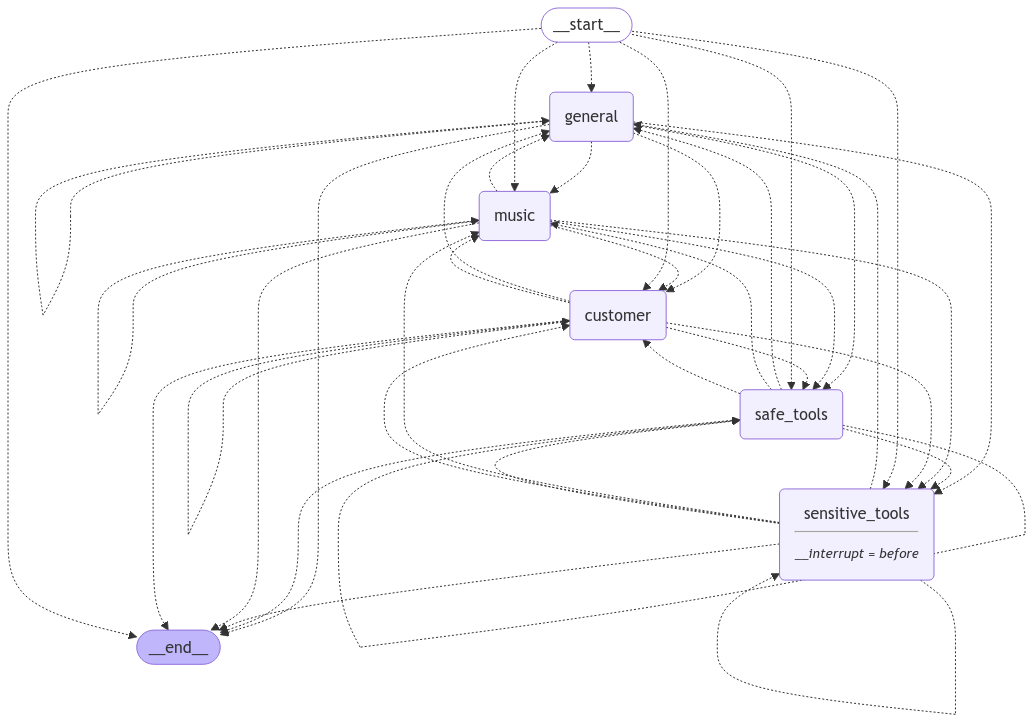

In [ ]:
from IPython.display import Image, display


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))



In [38]:
import ast 

# Query to get all artist names
artists = db.run("SELECT Name FROM artists;", include_columns=True)

# Print the list of artist names
print("Available Artists in the Database:")

artists = ast.literal_eval(artists)

artist_names = [artist['Name'] for artist in artists]

Available Artists in the Database:


In [39]:
"Amy Winehouse" in (artist_names)

True

In [40]:
ID = db.run("SELECT * from customers LIMIT 1;", include_columns=True)


In [41]:
ID

"[{'CustomerId': 1, 'FirstName': 'Luís', 'LastName': 'Gonçalves', 'Company': 'Embraer - Empresa Brasileira de Aeronáutica S.A.', 'Address': 'Av. Brigadeiro Faria Lima, 2170', 'City': 'São José dos Campos', 'State': 'SP', 'Country': 'Brazil', 'PostalCode': '12227-000', 'Phone': '+55 (12) 3923-5555', 'Fax': '+55 (12) 3923-5566', 'Email': 'babis@gmail.com', 'SupportRepId': 3}]"